In [2]:
###
# HW2
# Due: Feb 13th at 10am (prior to lecture)
# Covers lectures ... labs
###

In [5]:
'''
Problem 1
1a) As we discussed in class, simulation of a “real” liquid, such as a box of non-bonded particles at a given 
temperature and pressure, requires consideration of so-called periodic boundary conditions. In our simulation, 
we will assume the center of the box is at position 0,0,0 and that the initial vectors describing the extent of the 
box are equal (e.g., this box is a square!). 

Attached to this homework is a new XYZ file defining a box of 200 Lennard-Jones particles. The boundary vector for 
this box for a reasonable box temperature and pressure (we’ll get there later, don’t worry about this yet…) is 3.21829795. 
The total length of the box is twice the vector length in each dimension, so this box is 6.4365959 in length in each 
dimension (x, y, and z).

Implement a new total LJ potential function (as you did for problem 4(a) in the previous homework) which includes 
consideration of a periodic boundary, and compute the total potential for the system in the supplied new XYZ file 
(lj-0200-liquid.xyz). 

This will require you to correct the distance between atoms in each dimension. You may in the previous homework have 
written something like the following, which computes the distance based on the vector norm between the x, y, and z 
positions of two atoms, and the conditional defining your cutoff distance:

def distance(a, b):
    return np.linalg.norm(a - b)

def V_ij(r):
    return 4 *((1/r)**12 - (1/r)**6)

def lj_cut(a, r_cut):
    n_atoms = a.shape[0]
    LJ_potential = 0.0
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            r = distance(a[i], a[j])
            if r < r_cut:
                LJ_potential += V_ij(r)
    return LJ_potential

Because you will need to correct the distance between atoms in each dimension, based on the periodicity of the system. 
So this approach will not quite work: you will need to consider the distance in each dimension between the two particles 
in your double loop. In this case, it is easiest to consider the square euclidian distance, because it allows you to 
easily accumulate the distance in each dimension and then simply take a square root at the end. E.g., 

In pseudowords, a good approach to this is the following:

for each atom i in the system
  for each pairwise interaction atom j
    square_distance ← 0.0
    for each dim
      distance_in_dim ← a[i][dim] - a[j][dim]
      distance_in_dim -= boundary_length[dim] * \
        round(distance / boundary_length[dim])
      square_distance += distance_in_dim ** 2
    distance = sqrt(square_distance)
    if (distance < cutoff...)...

Where distance_in_dim is modified using the supplied function. 

1b) Compute the new potential energy for the system using your new function and a cutoff value of 2.0. Report the value.
'''
# (1a)
import numpy as np
def parse_xyz(f):
    n_atoms = int(f.readline())
    skip = f.readline()
    array = []
    for f in f.readlines():
        line = f.strip().split(' ')
        values = []
        for c in line[1:]:
            if c != '':
                values.append(float(c))
        array.append(values)
    return np.array(array).astype(np.float32)

def V_ij(r):
    return 4 *((1/r)**12 - (1/r)**6)

with open('../HW_files/lj-0200-liquid.xyz', 'r') as f:
    xyz_200_liq = parse_xyz(f)

boundary_lengths = np.array([6.4365959, 6.4365959, 6.4365959])

def period_dist(a, i, j, n_dim):
    sq_dist = 0.0
    for dim in range(n_dim):
        dist_in_dim = a[i][dim] - a[j][dim]
        dist_in_dim -= boundary_lengths[dim] * round(dist_in_dim / boundary_lengths[dim])
        sq_dist += dist_in_dim ** 2
    return np.sqrt(sq_dist)
    
def period_lj_cut(a, boundary_lengths, r_cut):
    n_atoms = a.shape[0]
    n_dim = a.shape[1]
    LJ_potential = 0.0
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            distance = period_dist(a, i, j, n_dim)
            if distance < r_cut:
                LJ_potential += V_ij(distance)
    return LJ_potential

# (1b)
print(period_lj_cut(xyz_200_liq, boundary_lengths, r_cut = 2.0))

-862.1552495456847


In [6]:
'''
Problem 2
We discussed two methods of list construction, the Verlet list, and the cell list, which can be implemented by an 
elementary hash table, and a linked list, respectively. 

First, we will implement a static Verlet list and rewrite our potential energy function once again to accommodate this 
new data structure. Constructing the list involves looping over all atom pairs, determining which pairs are within the 
cutoff + sheath distance, and constructing two arrays: a lookup table, where the location of pair information can be 
found for each atom, and a value table, where all pair atoms are found. The number of pairwise interactions per atom can 
be determined purely by the values in the lookup table, by comparing the position in the value table for the current and 
next atom.

Just like our previous attempt at a new potential function, periodicity must be considered. A pseudoword attempt at the 
list function might look like, for a cutoff of 2.0 and a sheath of 0.3:

cutoff ← 2.0
sheath ← 0.3
cutoff_plus_sheath ← cutoff + sheath
lookup ← empty numpy array of integers, length n_atoms
value ← unknown length, placeholder array
for each atom i in the system
  n_pairs ← 0
  for each pairwise interaction atom j
  square_distance ← 0.0s
    for each dim
      distance_in_dim ← a[i][dim] - a[j][dim]
      distance_in_dim -= boundary_length[dim] * \
        round(distance / boundary_length[dim])
      square_distance += distance_in_dim ** 2
    distance = sqrt(square_distance)
    if (distance < cutoff_plus_sheath)
      n_pairs ← n_pairs + 1
      value ← push pair index j onto array
  lookup[i] ← n_pairs

'''
def verlet_list(a, cutoff, sheath):
    n_atoms = a.shape[0]
    cutoff_plus_sheath = cutoff + sheath
    lookup = np.zeros(shape=[n_atoms]).astype(int)
    value = []
    for i in range(n_atoms):
        n_pairs = 0
        for j in range(i + 1, n_atoms):
            distance = period_dist(a, i, j, n_dim)
            if distance < cutoff + sheath:
                n_pairs += 1
                value.append(j)
        lookup[i] = n_pairs
    return np.array(value).astype(int), lookup

cutoff = 2.0
sheath = 0.3
n_dim = 3
value, lookup = verlet_list(xyz_200_liq, cutoff = 2.0, sheath = 0.3)

'''
After implementing the above pairwise function to generate a Verlet list, implement a total potential energy function 
that takes as input both arrays in the Verlet list, with appropriate control logic to only include those atoms within 
the cutoff but not within the sheath. Argue for why the complexity of this function is now O(N). 
'''

def vl_potential(value, lookup, cutoff, sheath, a):
    n_dim = a.shape[1]
    counter = 0
    LJ_potential = 0.0
    for i in range(len(lookup)):
        candidate_atoms = value[counter:(counter+lookup[i])]
        for j in range(len(candidate_atoms)):
            distance = period_dist(a, i, candidate_atoms[j], n_dim)
            if distance < cutoff:
                LJ_potential += V_ij(distance)
        counter += lookup[i]
    return LJ_potential

print(vl_potential(value, lookup, cutoff, sheath, xyz_200_liq))

# this has complexity of O(n) despite the double loop because the verlet list / hash table ensures that distances
# are only computed between pairs of relevant atoms and because the amount of lookups is linear, the overall 
# potential computation becomes linear

-862.1552495456847


In [7]:
'''
Now we will tackle the linked cell formulation, which is the first method we will cover to transform this 
problem into a true linear or logarithmetic problem. We will start with a very simple implementation of the cell 
list method, simply creating an appropriate set of linked lists, and continue to improve on our implementation with 
time once we start actually moving atoms in the simulation.

a) Given a fixed box length of 6.4365959 in all directions, and a cutoff of 2.0, what would be an appropriate size for a 
cell-based domain decomposition of this box? Why? (Hint: we covered this in the 4th week of class). 
'''
# linear dimension of cell must be larger than cutoff as so atoms do not interact with atoms in non adjacent cells

'''
b) Create an array of linked lists for a 3x3x3 (27 lists) decomposition of the array. How you index the position of each 
cell is up to you, but you need to know which area of the box each cell represents! Each node in each of the linked 
list should contain at a minimum a index value (the index of the atom) and a pointer to next. 
'''


class Node:
    def __init__(self,initdata):
        self.data = initdata
        self.next = None

    def getData(self):
        return self.data

    def getNext(self):
        return self.next

    def setData(self,newdata):
        self.data = newdata

    def setNext(self,newnext):
        self.next = newnext
        

class LinkedList:

    def __init__(self):
        self.head = None
        
    def isEmpty(self):
        return self.head == None

    def add(self,item):
        temp = Node(item)
        temp.setNext(self.head)
        self.head = temp
    
    
    

# here i, j, k are reflecting the bins with higher index values being positive i.e.
# i = 1 is -3.21 to -1.07, i = 2 is -1.07 to 1.07, and i = 3 is 1.07 to 3.21 
# same generalizes to other dimensions
ll_array = []
for i in range(3):
    x = [] 
    for j in range(3):
        y = [] 
        for k in range(3):
            z = LinkedList()
            y.append(z)
        x.append(y)
    ll_array.append(x)
ll_array = np.array(ll_array)



'''
Then,

Create an array or other data structure that specifies which cell neighbors are adjacent. Remember, in 3D each cell is 
26 neighbors with periodic boundary conditions! 
'''
cells = []
name_to_index = {}
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            name = str([i,j,k])
            cells.append(name)
            name_to_index[name] = [i,j,k]
            
coord_modifiers = []
for i in range(-1,2):
    for j in range(-1,2):
        for k in range(-1,2):
            coord_modifiers.append([i,j,k])
coord_modifiers.remove([0,0,0])

from collections import defaultdict
cell_to_adj = defaultdict(list)
for c in cells:
    for m in coord_modifiers:
        adj_cell = np.add(name_to_index[c], m)
        # convert -1 to 2
        # convert 3 to 0
        adj_cell = [2 if x == -1 else x for x in adj_cell]
        adj_cell = [0 if x == 3 else x for x in adj_cell]
        cell_to_adj[c].append(adj_cell)

'''
Implement an append function which allows you to easily add a new node 
to an arbitrary list by supplying the appropriate index to instantiate the node within the appropriate cell list. This 
method should handle the case where the linked list is empty and the head of the list has not yet been assigned.
'''


'''
Loop over all atoms in the simulation and assign them to a cell by instantiating a node in each cell as appropriate. 
'''
a = xyz_200_liq
box_len = 6.4365959 / 2
upper_bound = box_len / 3
lower_bound = -box_len / 3 
for i in range(a.shape[0]):
    coords = a[i]
    indices = []
    for j in coords:
        if j < lower_bound:
            indices.append(0)
        elif j > upper_bound:
            indices.append(2)
        else:
            indices.append(1)
    ll_array[indices[0],indices[1],indices[2]].add(i)
    


In [8]:
'''
Problem
In class we discussed the extension of the 1D peak problem to 2 dimensions. Write your own 2D peak implementation,
run it on the given array, and assess the complexity in terms of O(n) 
(in theory, not with doubling experiments unless you'd prefer!).
'''
import numpy as np
A = np.array([
    [1, 3, 10, 2],
    [14, 13, 12, 5],
    [15, 9, 11, 6],
    [16, 17, 13, 18]    
])
def two_peak(A, lo, hi):
    m = 0
    nrow = A.shape[0]
    j = (lo + hi)//2
    # find global max on column
    for i in range(nrow):
        if A[i][j] > m:
            m = A[i][j]
            mi, mj = i, j
    print(j, mi, mj, lo, hi, m)
    if mj == hi:
        return A[mi][mj]
    elif A[mi][mj] < A[mi][mj-1]:
        return two_peak(A, lo, mj-1)
    elif A[mi][mj] < A[mi][mj+1]:
        return two_peak(A, mj+1, hi)
    else:
        return A[mi][mj]
    
    
print(two_peak(A, 0, A.shape[1] - 1))
      

1 3 1 0 3 17
17


A_type: perf_sort
A_type: rev_sort
A_type: rand_order
A_type: id_order
A_type: 3_dist


'\nInterestingly, insertion sort performs the best under all cases - this is likely due to a) sample size is small,\nso worst case performances for insertion are avoided, and b) insertion uses less overhead memory, which might be\ndominating the run times of the other sorts.\n'

<Figure size 432x288 with 0 Axes>

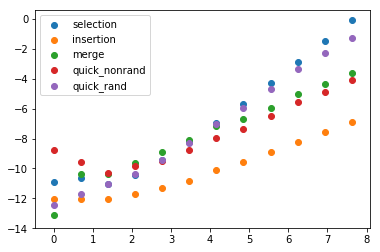

<Figure size 432x288 with 0 Axes>

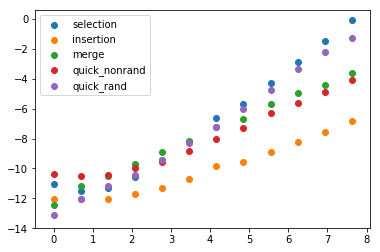

<Figure size 432x288 with 0 Axes>

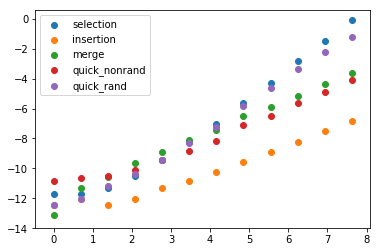

<Figure size 432x288 with 0 Axes>

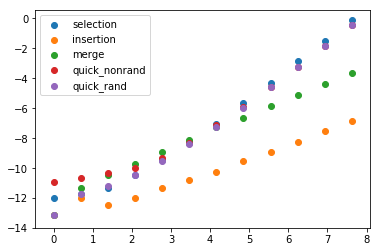

<Figure size 432x288 with 0 Axes>

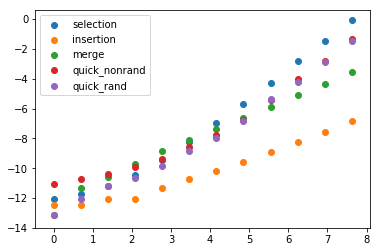

In [9]:
'''
Conduct doubling experiments to compare the run time of selection vs insertion vs merge vs 
quick (randomized vs non randomized) on various cases. Plot the results (all 5 sorts per case of array)
for array sizes n = 2, 4, ... 1024. The functions from lab are provided below - helper 'wrapper' functions for quick sort 
(randomized and nonrandomized) are also included so that all the sort functions are a function of an input array A only. 

The five cases are as follows:
(a) A is perfectly sorted and contains random integers 0 to 100 inclusive
(b) A is reverse sorted and contains random integers 0 to 100 inclusive
(c) A has a random order of integers from 0 to 100 inclusive
(d) A is made of entirely identical entries (all 1s)
(e) A is composed of 3 distinct entries (in random order) 0 1 2

Do the results agree with what you expect? 
'''
import time
import numpy as np

def selection_sort(A):
    for i in range(len(A)):
        min_idx = i
        for j in range(i + 1, len(A)):
            if A[min_idx] > A[j]:
                min_idx = j
        A[i], A[min_idx] = A[min_idx], A[i]
    return A

def insertion_sort(A):
    n = len(A)
    count = 0 
    for i in range(1,n):
        k = i
        while k > 0 and A[k] < A[k-1]:
            A[k], A[k-1] = A[k-1], A[k]
            k = k - 1
            count += 1
    return count, A

def merge (front, back):
    pos_f, pos_b = 0,0
    merged = np.zeros(len(front)+len(back))
    for i in range (len(merged)):
        if pos_f == len(front):
            merged[i] = back[pos_b]
            pos_b += 1
        elif pos_b == len(back):
            merged[i] = front[pos_f]
            pos_f += 1
        elif front[pos_f] < back[pos_b]:
            merged[i] = front[pos_f]
            pos_f += 1
        else:
            merged[i] = back[pos_b]
            pos_b += 1
    return merged

def merge_sort(A):
    n = len(A)
    if n <= 1:
        return A
    mid = int(n/2)
    front = merge_sort(A[0:mid])
    back = merge_sort(A[mid:])
    return merge(front, back)

def partition(A, lo, hi):
    pivotvalue = A[lo]
    i = lo+1    
    j = hi
    done = False
    while not done:
        while i <= j and A[i] <= pivotvalue:
            i = i + 1
        while A[j] >= pivotvalue and j >= i:
            j = j - 1
        if j < i:
            done = True
        else:
            A[i], A[j] = A[j], A[i]
    A[lo], A[j] = A[j], A[lo]
    return j, A


def quick_sort(A, lo, hi):
    if lo < hi:
        splitpoint, A = partition(A, lo, hi)
        A = quick_sort(A, lo, splitpoint - 1)
        A = quick_sort(A, splitpoint + 1, hi)    
    return A

def quick_sort_helper_rand(A):
    np.random.shuffle(A)
    return quick_sort(A, 0, len(A)-1)

def quick_sort_helper_nonrand(A):
    return quick_sort(A, 0, len(A)-1)

%matplotlib inline
import matplotlib.pyplot as plt

def time_trial(A, func):
    start = time.process_time()
    func(A)
    end = time.process_time() - start
    return end


str_to_func = {
    'selection': selection_sort, 
    'insertion': insertion_sort, 
    'merge': merge_sort, 
    'quick_nonrand': quick_sort_helper_rand, 
    'quick_rand': quick_sort_helper_nonrand
}   
sorts = ['selection', 'insertion', 'merge', 'quick_nonrand', 'quick_rand']    
a_types = ['perf_sort', 'rev_sort', 'rand_order', 'id_order', '3_dist']
atype_to_data = {}
for a in a_types:
    atype_to_data[a] = {}
    for s in sorts:
        atype_to_data[a][s] = []

n_list = []
n = 1
n_max = 4000
while n < n_max:
    str_to_array = {
        'perf_sort': np.sort(np.random.randint(low=0,high=1001,size=n)),
        'rev_sort': np.sort(np.random.randint(low=0,high=1001,size=n))[::-1],
        'rand_order': np.random.randint(low=0,high=1001,size=n),
        'id_order': np.ones(shape=[n]),
        '3_dist': np.random.randint(low=0,high=3,size=n)
    }
    for a in str_to_array:
        A = str_to_array[a]
        for s in sorts:
            atype_to_data[a][s].append(time_trial(A, str_to_func[s]))
    n_list.append(n)
    n = n * 2
    

for a in a_types:
    for s in sorts:
        atype_to_data[a][s] = np.log(np.array(atype_to_data[a][s]))

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

for a in a_types:
    df = pd.DataFrame(atype_to_data[a])
    df['logn'] = np.log(n_list)
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()
    print('A_type: ' + a)
    for s in sorts:
        plt.scatter(df['logn'], df[s])
    ax.legend()
    
'''
Interestingly, insertion sort performs the best under all cases - this is likely due to a) sample size is small,
so worst case performances for insertion are avoided, and b) insertion uses less overhead memory, which might be
dominating the run times of the other sorts.
'''
        

In [1]:
'''
Problem 6
Solve the following recurrences (i.e. find a closed form expression for n)
(a) 
S(0) = 6 for n = 0
S(n) = S(n-1) + 2 for n = 1, 2, 3, ... 

S(n) = 2n + 6

1. Write it out
S(0) = 6
S(1) = S(0) + 2 = 6 + 2 = 8
S(2) = S(1) + 2 = 8 + 2 = 10
Expect something like 2n + 6 from pattern
2. Write it out algebraically 
S(n) = S(n-1) + 2
S(n-1) = S(n-2) + 2
S(n-2) = S(n-3) + 2
therefore
S(n) = (S(n-2) + 2) + 2
S(n) = (S(n-3) + 2) + 2 + 2
...
S(n) = (S(n-k) + 2k)
Substitute n - k = 0 to substitute boundary condition S(0) = 6
S(n) = (S(0) + 2(n)) # since n - k = 0, n = k
S(n) = 6 + 2n

(b)
T(1) = 2 for n = 1
T(n) = 2T(n-1) + 4 for n = 2, 3, 4, ...

T(n) = 2^n + 4 * sum_{i = 1}^{n-1} 2^(i-1)

1. Write it out
T(1) = 2
T(2) = 2T(1) + 4 = 8
T(3) = 2t(2) + 4 = 20
... not obvious what the pattern is
2. Write it out algebraically 
T(n) = 2T(n-1) + 4
T(n-1) = 2T(n-2) + 4
T(n-2) = 2T(n-3) + 4 
therefore
T(n) = 2(2T(n-2) + 4) + 4
T(n) = 2(2(2T(n-3) + 4) + 4) + 4
T(n) = 2^3 * T(n-3) + 16 + 8 + 4
T(n) = 2^k T(n-k) + 4 * (2^k - 1)
Substitute boundary condition knowing that n - k = 1 (T(1) = 2) so k = n - 1
T(n) = 2^(n-1) * T(1) + 4 * (2^(n-1) - 1)
T(n) = 2^n + 2 * 2^n - 4
T(n) = 2^n(1 + 2) - 4
T(n) = 3*2^n - 4

(c) BONUS
Q(1) = c for n = 1
Q(n) = Q(n/2) + 2n for n = 2, 4, 8, ...

1. No concrete numbers - skip this
2. Write it out algebraically
Q(n) = Q(n/2) + 2n
Q(n/2) = Q(n/4) + n
Q(n/4) = Q(n/8) + n/2
Q(n) = Q(n/4) + n + 2n
Q(n) = Q(n/8) + n/2 + n + 2n 
Q(n) = Q(n/(2^k)) + 4n(1/8 + 1/4 + 1/2)
Q(n) = Q(n/(2^k)) + 4n(1 - 1/(2^k)) 
For boundary condition, set n/(2^k) = 1 leaving k = log_2(n)
Q(n) = Q(1) + 4n(1 - 1/(2^(log_2(n))))
Q(n) = c + 4n(1 - 1/n)

 
'''

'''
Problem 7
The number of comparisons in merge sort can be written as 
T(1) = 0 for n = 1, 
(a subarray of 1 element requires no comparisons)
T(n) = 2T(n/2) + (n-1) for n = 2, 4, 8 ...
(derived from T(n/2) comparisons to get the first half of the array, another T(n/2) for the second half,
and n-1 to merge them)
What is a closed form expression for T(n)?

Writing the first few terms:
T(n) = 2T(n/2) + (n-1)
T(n/2) = 2T(n/4) + (n/2-1)
T(n/4) = 2T(n/8) + (n/4-1)

We compile them
T(n) = 2T(n/2) + (n-1)
T(n) = 2(2T(n/4) + n/2 - 1) + (n-1)
T(n) = 2(2(2T(n/8) + n/4 - 1) + n/2 - 1) + (n-1)
T(n) = 8T(n/8) + (n - 4) + (n - 2) + (n - 1)

For generic k,
T(n) = 2^kT(n/(2^k)) + kn - (2^k - 1)

Substituting initial conditions, we have
n / (2^k) = 1, or k = log_2(n)

T(n) = 2^kT(n/(2^k)) + kn - (2^k - 1)
T(n) = nT(1) + nlog_2(n) - (n - 1)
T(n) = n(0) + nlog_2(n) - n + 1
T(n) = nlog_2(n) - n + 1

'''



'''
Problem 8
Towards a better quicksort.
(a)  Draw traces to show what happens when you pivot on using 13 as the pivot when partition (as defined in lab)
is called i.e. 
A = [13, 19, 9, 5, 9, 8, 11, 9, 6]
partition(A, lo = 0, hi = len(A)-1)

A = [13, 19, 9, 5, 9, 8, 11, 9, 6]
swap 6 and 19

A = [13, 6, 9, 5, 9, 8, 11, 9, 19]
nothing left to swap, switch 13 and 9

A = [9, 6, 9, 5, 9, 8, 11, 13, 19]

(b) So far we've discussed quicksort that partitions each array into two components based on a pivot v
(one portion greater than or equal to v, the other half less than or equal to v). However, 
such a partition can lead to potentially poor performances when the array contains duplicates. Here
we implement a 3-way quicksort that partitions the array into thirds. Convert the following from pseudocode to Python

quicksort_3way(A, lo, hi)
    if hi <= lo
        return A
    lt, i, gt = lo, lo + 1, hi
    v = A[lo]
    while i <= gt
        if A[i] < v
            exchange A[lt], A[i]
            increase i and lt by 1
        elif A[i] > v
            exchange A[i], A[gt]
            decrease gt by 1
        else
            increase i by 1
    A <- quicksort_3way(A, lo, lt - 1)
    A <- quicksort_3way(A, gt + 1, hi)
return A

(c) what value does i terminate on (in the first outermost recursive call) when quicksort_3way 
runs with pivot value 2 on the following array?
A = [2, 3, 1, 2, 2, 2, 3, 3]
quicksort_3way(A, 0, len(A) - 1)

[1, 2, 2, 2, 2, 3, 3, 3]
i is programmed to sweep through the 2's and stops upon reaching the first greater than 2 value / index
i = 5

'''
A = [1, 3, 1, 2, 2, 2, 3, 3]

def quicksort_3way(A, lo, hi):
    if hi <= lo:
        return A
    lt = lo
    i = lo + 1
    gt = hi
    v = A[lo]
    while i <= gt:
        if A[i] < v:
            A[lt], A[i] = A[i], A[lt]
            i += 1
            lt += 1
        elif A[i] > v:
            A[i], A[gt] = A[gt], A[i]
            gt -= 1
        else:
            i += 1
    A = quicksort_3way(A, lo, lt - 1)
    A = quicksort_3way(A, gt + 1, hi)
    return A

print(quicksort_3way(A, 0, len(A) - 1))

'''
Problem 9
Consider the following sorting algorithm:
Funny-sort (A, i,j): 
    if A[i] > A[j]
        Exchange A[i] <-> A[j]
    if (i + 1)>= j
        return
    k <- int((j-i+1)/3) #basically the "int" function acts as floor
    Funny-sort(A, i, j-k) 
    Funny-sort(A, i+k, j) 
    Funny-sort(A, i, j-k)

a.) Does this correctly sort the array? Why?

Note that it :
- sorts the first two thirds.
    At this point the last third has not been touched, therefore it is not in
    sorted order and could contain elements smaller than the first third.
    I.e. not element in the vector is in its correct place.
- sorts the last two thirds.
    At this point we know that the last third is now in its correct place. How do we know that? 
    After iteration 1 the middle third had elements greater than the first third. Therefore, to get the position of the 
    last third of elements you just need to compare the unsorted portion to this middle third.
    The first two thirds is not necessarily in sorted order still! 
- Sort the first 2/3
    Based on the fact that the last third is sorted – we’re done!

b.) Give a recurrence for this (e.g. something like T(n) = ?)

T(n) = 3*T(2n/3) + O(1)

c.) Ignoring constant factors and smaller terms, guess whether the worst case (O(n)) 
running time is better, the same, or worse than MergeSort?

Worse

d.) BONUS: Can you figure out the worst case run time? (e.g. O(?)) HINT: The master theorem says that given a recurrence
of form aT(n/b) + f(n) where a, b are constants greater than or equal to 1 and f(n) = n^c, then in the following
3 cases:
(1) if c > log_b(a), then T(n) = O(n^c)
(2) if c = log_b(a), then T(n) = O( n^c log(n) )
(3) if c < log_b(a), then T(n) = O(n^[log_b(a)])

Falls in case 3 of mastertheorem, with c = 0 and log_b(a) = log_{3/2}(3) yielding runtime of O(n^log3/log1.5) ~ O(n^2.7)
'''

[1, 1, 2, 2, 2, 3, 3, 3]


'\nConsider the following sorting algorithm:\nFunny-sort (A, i,j): \n    if A[i] > A[j]\n        Exchange A[i] <-> A[j]\n    if (i + 1)>= j\n        return\n    k <- int((j-i+1)/3) #basically the "int" function acts as floor\n    Funny-sort(A, i, j-k) \n    Funny-sort(A, i+k, j) \n    Funny-sort(A, i, j-k)\n\na.) Does this correctly sort the array? Why?\n\nNote that it :\n- sorts the first two thirds.\n    At this point the last third has not been touched, therefore it is not in\n    sorted order and could contain elements smaller than the first third.\n    I.e. not element in the vector is in its correct place.\n- sorts the last two thirds.\n    At this point we know that the last third is now in its correct place. How do we know that? \n    After iteration 1 the middle third had elements greater than the first third. Therefore, to get the position of the \n    last third of elements you just need to compare the unsorted portion to this middle third.\n    The first two thirds is not n